In [3]:
import polars as pl
import time

SOURCE_FILE = "201201hourly.txt"
OUTPUT_FILE = "weather_2012Jan.parquet"

# --- 1. Define Column Names and Schema ---
# (Using ALL_COLUMNS, MY_SCHEMA, and NUMERIC_COLS from Step 1)

ALL_COLUMNS = [
    'WBAN', 'Date', 'Time', 'StationType', 'SkyCondition', 'SkyConditionFlag',
    'Visibility', 'VisibilityFlag', 'WeatherType', 'WeatherTypeFlag',
    'DryBulbFarenheit', 'DryBulbFarenheitFlag', 'DryBulbCelsius', 'DryBulbCelsiusFlag',
    'WetBulbFarenheit', 'WetBulbFarenheitFlag', 'WetBulbCelsius', 'WetBulbCelsiusFlag',
    'DewPointFarenheit', 'DewPointFarenheitFlag', 'DewPointCelsius', 'DewPointCelsiusFlag',
    'RelativeHumidity', 'RelativeHumidityFlag', 'WindSpeed', 'WindSpeedFlag',
    'WindDirection', 'WindDirectionFlag', 'ValueForWindCharacter', 'ValueForWindCharacterFlag',
    'StationPressure', 'StationPressureFlag', 'PressureTendency', 'PressureTendencyFlag',
    'PressureChange', 'PressureChangeFlag', 'SeaLevelPressure', 'SeaLevelPressureFlag',
    'RecordType', 'RecordTypeFlag', 'HourlyPrecip', 'HourlyPrecipFlag',
    'Altimeter', 'AltimeterFlag'
]

# Safest schema: Read all as strings
MY_SCHEMA = {col: pl.String for col in ALL_COLUMNS}

# List of columns that should be numbers
NUMERIC_COLS = [
    'Visibility', 'DryBulbFarenheit', 'DryBulbCelsius', 'WetBulbFarenheit',
    'WetBulbCelsius', 'DewPointFarenheit', 'DewPointCelsius', 'RelativeHumidity',
    'WindSpeed', 'StationPressure', 'PressureTendency', 'PressureChange',
    'SeaLevelPressure', 'HourlyPrecip', 'Altimeter'
]

print(f"Starting transformation of {SOURCE_FILE}...")
start_time = time.time()

try:
    # --- 2. Create the Lazy Plan ---
    lazy_df = pl.scan_csv(
        SOURCE_FILE,
        has_header=True,
        separator=",",
        # ✅ FIX 1: Renamed 'dtypes' to 'schema_overrides'
        schema_overrides=MY_SCHEMA,
        low_memory=True
    )

# --- 3. Add Cleaning & Transformation Steps to the Plan ---
    lazy_df = lazy_df.with_columns(

        # ✅ FIX 2: Added 'strict=False' to the cast
        # This turns "M", "", " ", and other non-numeric text into null
        pl.col(NUMERIC_COLS)
            .str.strip_chars()
            .replace("M", None)
            .cast(pl.Float64, strict=False), # <-- Turn cast errors into null

        # Also apply 'strict=False' to other casts
        pl.col("StationType")
            .str.strip_chars()
            .cast(pl.Int64, strict=False), # <-- Turn cast errors into null

        pl.col("WindDirection").str.strip_chars(),

        # Create a single, proper datetime column
        pl.concat_str(
            [pl.col("Date"), pl.col("Time")],
            separator=""
        ).str.to_datetime(
            format="%Y%m%d%H%M",
            strict=False # Be flexible with date parsing too
        ).alias("Timestamp")

    ).drop(["Date", "Time"]) # Drop the original string columns


    # --- 4. Execute the Plan and Sink to Parquet ---
    lazy_df.sink_parquet(
        OUTPUT_FILE,
        compression="zstd"
    )

    end_time = time.time()
    print(f"✅ Success! File converted to {OUTPUT_FILE} in {end_time - start_time:.2f} seconds.")

except Exception as e:
    print(f"An error occurred: {e}")

# --- 5. (Optional) Verify the result ---
print("\nVerifying the new Parquet file (reading first 5 rows):")
try:
    df_parquet = pl.read_parquet(OUTPUT_FILE, n_rows=5)
    print(df_parquet)
    print("\nSchema of new Parquet file:")
    print(df_parquet.schema)
except Exception as e:
    print(f"Could not read back Parquet file: {e}")

Starting transformation of 201201hourly.txt...
✅ Success! File converted to weather_2012Jan.parquet in 3.49 seconds.

Verifying the new Parquet file (reading first 5 rows):
shape: (5, 43)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ WBAN  ┆ StationTyp ┆ SkyConditi ┆ SkyConditi ┆ … ┆ HourlyPre ┆ Altimeter ┆ Altimeter ┆ Timestamp │
│ ---   ┆ e          ┆ on         ┆ onFlag     ┆   ┆ cipFlag   ┆ ---       ┆ Flag      ┆ ---       │
│ str   ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆ f64       ┆ ---       ┆ datetime[ │
│       ┆ i64        ┆ str        ┆ str        ┆   ┆ str       ┆           ┆ str       ┆ μs]       │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 03011 ┆ 0          ┆ CLR        ┆            ┆ … ┆           ┆ 30.43     ┆           ┆ 2012-01-0 │
│       ┆            ┆            ┆            ┆   ┆           ┆           ┆           ┆ 1         │
│   

In [4]:

# --- Configuration ---
INPUT_FILE = "weather_2012Jan.parquet"

# --- 1. Lazily Scan the Parquet File ---
# This is instant and uses no memory
try:
    lazy_df = pl.scan_parquet(INPUT_FILE)
    print(f"Successfully scanned {INPUT_FILE}")
    print("Schema of our clean data:")
    print(lazy_df.schema)
    print("-" * 30)

    # --- 2. Get Summary Statistics ---
    # .describe() is a great EDA tool.
    # We call .collect() because we need to compute the result to print it.
    print("Summary Statistics (for numeric columns):")
    summary_stats = lazy_df.describe()
    print(summary_stats)
    print("-" * 30)

    # --- 3. Check for Missing Values ---
    # Let's see how many nulls we have in key columns.
    null_counts = lazy_df.select(
        pl.col("DryBulbCelsius").null_count().alias("Nulls_Temp_C"),
        pl.col("Visibility").null_count().alias("Nulls_Visibility"),
        pl.col("WindSpeed").null_count().alias("Nulls_WindSpeed"),
        pl.col("Timestamp").null_count().alias("Nulls_Timestamp")
    ).collect()
    
    print("Missing Value Counts:")
    print(null_counts)
    print("-" * 30)

    # --- 4. Check Categorical Data ---
    # How many unique weather stations are in this file?
    unique_stations = lazy_df.select(
        pl.col("WBAN").n_unique().alias("num_unique_stations")
    ).collect()
    print(f"Station (WBAN) Info:")
    print(unique_stations)
    
    # What are the most common sky conditions?
    # We use .head(10) in the query to keep the result small
    common_sky = lazy_df.group_by("SkyCondition").count().sort(
        "count", descending=True
    ).head(10).collect()

    print("\nTop 10 Most Common Sky Conditions:")
    print(common_sky)
    print("-" * 30)
    
    # --- 5. Check Time Range ---
    time_range = lazy_df.select(
        pl.col("Timestamp").min().alias("start_time"),
        pl.col("Timestamp").max().alias("end_time")
    ).collect()
    
    print("Data Time Range:")
    print(time_range)
    print("-" * 30)


except Exception as e:
    print(f"An error occurred during EDA: {e}")

Successfully scanned weather_2012Jan.parquet
Schema of our clean data:
Schema({'WBAN': String, 'StationType': Int64, 'SkyCondition': String, 'SkyConditionFlag': String, 'Visibility': Float64, 'VisibilityFlag': String, 'WeatherType': String, 'WeatherTypeFlag': String, 'DryBulbFarenheit': Float64, 'DryBulbFarenheitFlag': String, 'DryBulbCelsius': Float64, 'DryBulbCelsiusFlag': String, 'WetBulbFarenheit': Float64, 'WetBulbFarenheitFlag': String, 'WetBulbCelsius': Float64, 'WetBulbCelsiusFlag': String, 'DewPointFarenheit': Float64, 'DewPointFarenheitFlag': String, 'DewPointCelsius': Float64, 'DewPointCelsiusFlag': String, 'RelativeHumidity': Float64, 'RelativeHumidityFlag': String, 'WindSpeed': Float64, 'WindSpeedFlag': String, 'WindDirection': String, 'WindDirectionFlag': String, 'ValueForWindCharacter': String, 'ValueForWindCharacterFlag': String, 'StationPressure': Float64, 'StationPressureFlag': String, 'PressureTendency': Float64, 'PressureTendencyFlag': String, 'PressureChange': Floa

/var/folders/7c/qp7l8dn113s86r0x70snm3kw0000gn/T/ipykernel_2803/1605230933.py:10: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  print(lazy_df.schema)


An error occurred during EDA: 'DataFrame' object has no attribute 'collect'


## Fix: The error occurs because `lazy_df.describe()` returns a DataFrame, not a LazyFrame, so calling `.collect()` on it fails.

The solution is to remove the `.collect()` call after `.describe()` since it already returns an eager DataFrame.

In [7]:
# --- Configuration ---
INPUT_FILE = "weather_2012Jan.parquet"

# --- 1. Lazily Scan the Parquet File ---
try:
    lazy_df = pl.scan_parquet(INPUT_FILE)
    print(f"Successfully scanned {INPUT_FILE}")
    print("Schema of our clean data:")
    print(lazy_df.collect_schema())
    print("-" * 30)

    # --- 2. Get Summary Statistics ---
    print("Summary Statistics (for numeric columns):")
    summary_stats = lazy_df.describe()
    print(summary_stats)
    print("-" * 30)

    # --- 3. Check for Missing Values ---
    null_counts = lazy_df.select(
        pl.col("DryBulbCelsius").null_count().alias("Nulls_Temp_C"),
        pl.col("Visibility").null_count().alias("Nulls_Visibility"),
        pl.col("WindSpeed").null_count().alias("Nulls_WindSpeed"),
        pl.col("Timestamp").null_count().alias("Nulls_Timestamp")
    ).collect()

    print("Missing Value Counts:")
    print(null_counts)
    print("-" * 30)

    # --- 4. Check Categorical Data ---
    unique_stations = lazy_df.select(
        pl.col("WBAN").n_unique().alias("num_unique_stations")
    ).collect()
    print(f"Station (WBAN) Info:")
    print(unique_stations)

    common_sky = lazy_df.group_by("SkyCondition").count().sort(
        "count", descending=True
    ).head(10).collect()

    print("\nTop 10 Most Common Sky Conditions:")
    print(common_sky)
    print("-" * 30)

    # --- 5. Check Time Range ---
    time_range = lazy_df.select(
        pl.col("Timestamp").min().alias("start_time"),
        pl.col("Timestamp").max().alias("end_time")
    ).collect()

    print("Data Time Range:")
    print(time_range)
    print("-" * 30)

except Exception as e:
    print(f"An error occurred during EDA: {e}")


Successfully scanned weather_2012Jan.parquet
Schema of our clean data:
Schema({'WBAN': String, 'StationType': Int64, 'SkyCondition': String, 'SkyConditionFlag': String, 'Visibility': Float64, 'VisibilityFlag': String, 'WeatherType': String, 'WeatherTypeFlag': String, 'DryBulbFarenheit': Float64, 'DryBulbFarenheitFlag': String, 'DryBulbCelsius': Float64, 'DryBulbCelsiusFlag': String, 'WetBulbFarenheit': Float64, 'WetBulbFarenheitFlag': String, 'WetBulbCelsius': Float64, 'WetBulbCelsiusFlag': String, 'DewPointFarenheit': Float64, 'DewPointFarenheitFlag': String, 'DewPointCelsius': Float64, 'DewPointCelsiusFlag': String, 'RelativeHumidity': Float64, 'RelativeHumidityFlag': String, 'WindSpeed': Float64, 'WindSpeedFlag': String, 'WindDirection': String, 'WindDirectionFlag': String, 'ValueForWindCharacter': String, 'ValueForWindCharacterFlag': String, 'StationPressure': Float64, 'StationPressureFlag': String, 'PressureTendency': Float64, 'PressureTendencyFlag': String, 'PressureChange': Floa

/var/folders/7c/qp7l8dn113s86r0x70snm3kw0000gn/T/ipykernel_2803/3726211651.py:37: DeprecationWarning: `count` was renamed; use `len` instead
  common_sky = lazy_df.group_by("SkyCondition").count().sort(


# Comprehensive EDA - Distribution Analysis for All Non-Null Variables

In [8]:
df = lazy_df.collect()

In [9]:
print("Dataset Shape:", df.shape)
print("\nColumn Names and Types:")
print(df.schema)

Dataset Shape: (4192912, 43)

Column Names and Types:
Schema({'WBAN': String, 'StationType': Int64, 'SkyCondition': String, 'SkyConditionFlag': String, 'Visibility': Float64, 'VisibilityFlag': String, 'WeatherType': String, 'WeatherTypeFlag': String, 'DryBulbFarenheit': Float64, 'DryBulbFarenheitFlag': String, 'DryBulbCelsius': Float64, 'DryBulbCelsiusFlag': String, 'WetBulbFarenheit': Float64, 'WetBulbFarenheitFlag': String, 'WetBulbCelsius': Float64, 'WetBulbCelsiusFlag': String, 'DewPointFarenheit': Float64, 'DewPointFarenheitFlag': String, 'DewPointCelsius': Float64, 'DewPointCelsiusFlag': String, 'RelativeHumidity': Float64, 'RelativeHumidityFlag': String, 'WindSpeed': Float64, 'WindSpeedFlag': String, 'WindDirection': String, 'WindDirectionFlag': String, 'ValueForWindCharacter': String, 'ValueForWindCharacterFlag': String, 'StationPressure': Float64, 'StationPressureFlag': String, 'PressureTendency': Float64, 'PressureTendencyFlag': String, 'PressureChange': Float64, 'PressureCha

In [10]:
print("\nNull Counts for All Columns:")
null_summary = df.null_count()
null_summary


Null Counts for All Columns:


WBAN,StationType,SkyCondition,SkyConditionFlag,Visibility,VisibilityFlag,WeatherType,WeatherTypeFlag,DryBulbFarenheit,DryBulbFarenheitFlag,DryBulbCelsius,DryBulbCelsiusFlag,WetBulbFarenheit,WetBulbFarenheitFlag,WetBulbCelsius,WetBulbCelsiusFlag,DewPointFarenheit,DewPointFarenheitFlag,DewPointCelsius,DewPointCelsiusFlag,RelativeHumidity,RelativeHumidityFlag,WindSpeed,WindSpeedFlag,WindDirection,WindDirectionFlag,ValueForWindCharacter,ValueForWindCharacterFlag,StationPressure,StationPressureFlag,PressureTendency,PressureTendencyFlag,PressureChange,PressureChangeFlag,SeaLevelPressure,SeaLevelPressureFlag,RecordType,RecordTypeFlag,HourlyPrecip,HourlyPrecipFlag,Altimeter,AltimeterFlag,Timestamp
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,1831790,0,0,0,24007,0,24007,0,1895363,0,1895363,0,1858712,0,1858712,0,1895363,0,1682659,0,0,0,0,0,1833248,0,3904451,0,3904451,0,3374492,0,0,0,4096684,0,1805797,0,0


In [11]:
non_null_percentage = df.select([
    ((pl.col(col).count() / df.height) * 100).alias(f"{col}_non_null_%")
    for col in df.columns
])
print("\nNon-Null Percentage for Each Column:")
non_null_percentage


Non-Null Percentage for Each Column:


WBAN_non_null_%,StationType_non_null_%,SkyCondition_non_null_%,SkyConditionFlag_non_null_%,Visibility_non_null_%,VisibilityFlag_non_null_%,WeatherType_non_null_%,WeatherTypeFlag_non_null_%,DryBulbFarenheit_non_null_%,DryBulbFarenheitFlag_non_null_%,DryBulbCelsius_non_null_%,DryBulbCelsiusFlag_non_null_%,WetBulbFarenheit_non_null_%,WetBulbFarenheitFlag_non_null_%,WetBulbCelsius_non_null_%,WetBulbCelsiusFlag_non_null_%,DewPointFarenheit_non_null_%,DewPointFarenheitFlag_non_null_%,DewPointCelsius_non_null_%,DewPointCelsiusFlag_non_null_%,RelativeHumidity_non_null_%,RelativeHumidityFlag_non_null_%,WindSpeed_non_null_%,WindSpeedFlag_non_null_%,WindDirection_non_null_%,WindDirectionFlag_non_null_%,ValueForWindCharacter_non_null_%,ValueForWindCharacterFlag_non_null_%,StationPressure_non_null_%,StationPressureFlag_non_null_%,PressureTendency_non_null_%,PressureTendencyFlag_non_null_%,PressureChange_non_null_%,PressureChangeFlag_non_null_%,SeaLevelPressure_non_null_%,SeaLevelPressureFlag_non_null_%,RecordType_non_null_%,RecordTypeFlag_non_null_%,HourlyPrecip_non_null_%,HourlyPrecipFlag_non_null_%,Altimeter_non_null_%,AltimeterFlag_non_null_%,Timestamp_non_null_%
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
100.0,100.0,100.0,100.0,56.312224,100.0,100.0,100.0,99.427438,100.0,99.427438,100.0,54.796022,100.0,54.796022,100.0,55.67014,100.0,55.67014,100.0,54.796022,100.0,59.868965,100.0,100.0,100.0,100.0,100.0,56.277451,100.0,6.879729,100.0,6.879729,100.0,19.519131,100.0,100.0,100.0,2.295016,100.0,56.932151,100.0,100.0


In [12]:
numeric_columns = [col for col in df.columns if df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]]
print(f"\nNumeric columns ({len(numeric_columns)}):")
print(numeric_columns)


Numeric columns (16):
['StationType', 'Visibility', 'DryBulbFarenheit', 'DryBulbCelsius', 'WetBulbFarenheit', 'WetBulbCelsius', 'DewPointFarenheit', 'DewPointCelsius', 'RelativeHumidity', 'WindSpeed', 'StationPressure', 'PressureTendency', 'PressureChange', 'SeaLevelPressure', 'HourlyPrecip', 'Altimeter']


In [13]:
categorical_columns = [col for col in df.columns if df[col].dtype == pl.String]
print(f"\nCategorical columns ({len(categorical_columns)}):")
print(categorical_columns)


Categorical columns (26):
['WBAN', 'SkyCondition', 'SkyConditionFlag', 'VisibilityFlag', 'WeatherType', 'WeatherTypeFlag', 'DryBulbFarenheitFlag', 'DryBulbCelsiusFlag', 'WetBulbFarenheitFlag', 'WetBulbCelsiusFlag', 'DewPointFarenheitFlag', 'DewPointCelsiusFlag', 'RelativeHumidityFlag', 'WindSpeedFlag', 'WindDirection', 'WindDirectionFlag', 'ValueForWindCharacter', 'ValueForWindCharacterFlag', 'StationPressureFlag', 'PressureTendencyFlag', 'PressureChangeFlag', 'SeaLevelPressureFlag', 'RecordType', 'RecordTypeFlag', 'HourlyPrecipFlag', 'AltimeterFlag']


## Distribution Plots for Numeric Variables

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_numeric_distributions(df, columns, cols_per_row=3):
    non_null_cols = [col for col in columns if df[col].null_count() < df.height]
    
    if not non_null_cols:
        print("No numeric columns with non-null values found")
        return
    
    num_cols = len(non_null_cols)
    rows = (num_cols + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows))
    axes = axes.flatten() if num_cols > 1 else [axes]
    
    for idx, col in enumerate(non_null_cols):
        ax = axes[idx]
        data = df[col].drop_nulls()
        ax.hist(data, bins=30, edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
    
    for idx in range(num_cols, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

plot_numeric_distributions(df, numeric_columns)

## Distribution Analysis for Categorical Variables

In [ ]:
def analyze_categorical_distributions(df, columns, top_n=10):
    for col in columns:
        non_null_count = df[col].drop_nulls().height

        if non_null_count == 0:
            print(f"\n{col}: All values are null")
            continue

        print(f"\n{'=' * 60}")
        print(f"Column: {col}")
        print(f"Non-null count: {non_null_count:,}")
        print(f"Unique values: {df[col].n_unique()}")

        value_counts = df.group_by(col).count().sort("count", descending=True).head(top_n)
        print(f"\nTop {top_n} most common values:")
        print(value_counts)


analyze_categorical_distributions(df, categorical_columns)

## Visualization of Top Categorical Variables

In [ ]:
def plot_categorical_distributions(df, columns, top_n=10):
    non_null_cols = [col for col in columns if df[col].drop_nulls().height > 0]

    for col in non_null_cols:
        value_counts = df.group_by(col).count().sort("count", descending=True).head(top_n).to_pandas()

        if len(value_counts) == 0:
            continue

        plt.figure(figsize=(12, 6))
        plt.bar(range(len(value_counts)), value_counts['count'], color='coral', edgecolor='black')
        plt.xticks(range(len(value_counts)), value_counts[col], rotation=45, ha='right')
        plt.title(f'Top {top_n} Values Distribution: {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()


plot_categorical_distributions(df, categorical_columns)

## Box Plots for Numeric Variables (Outlier Detection)

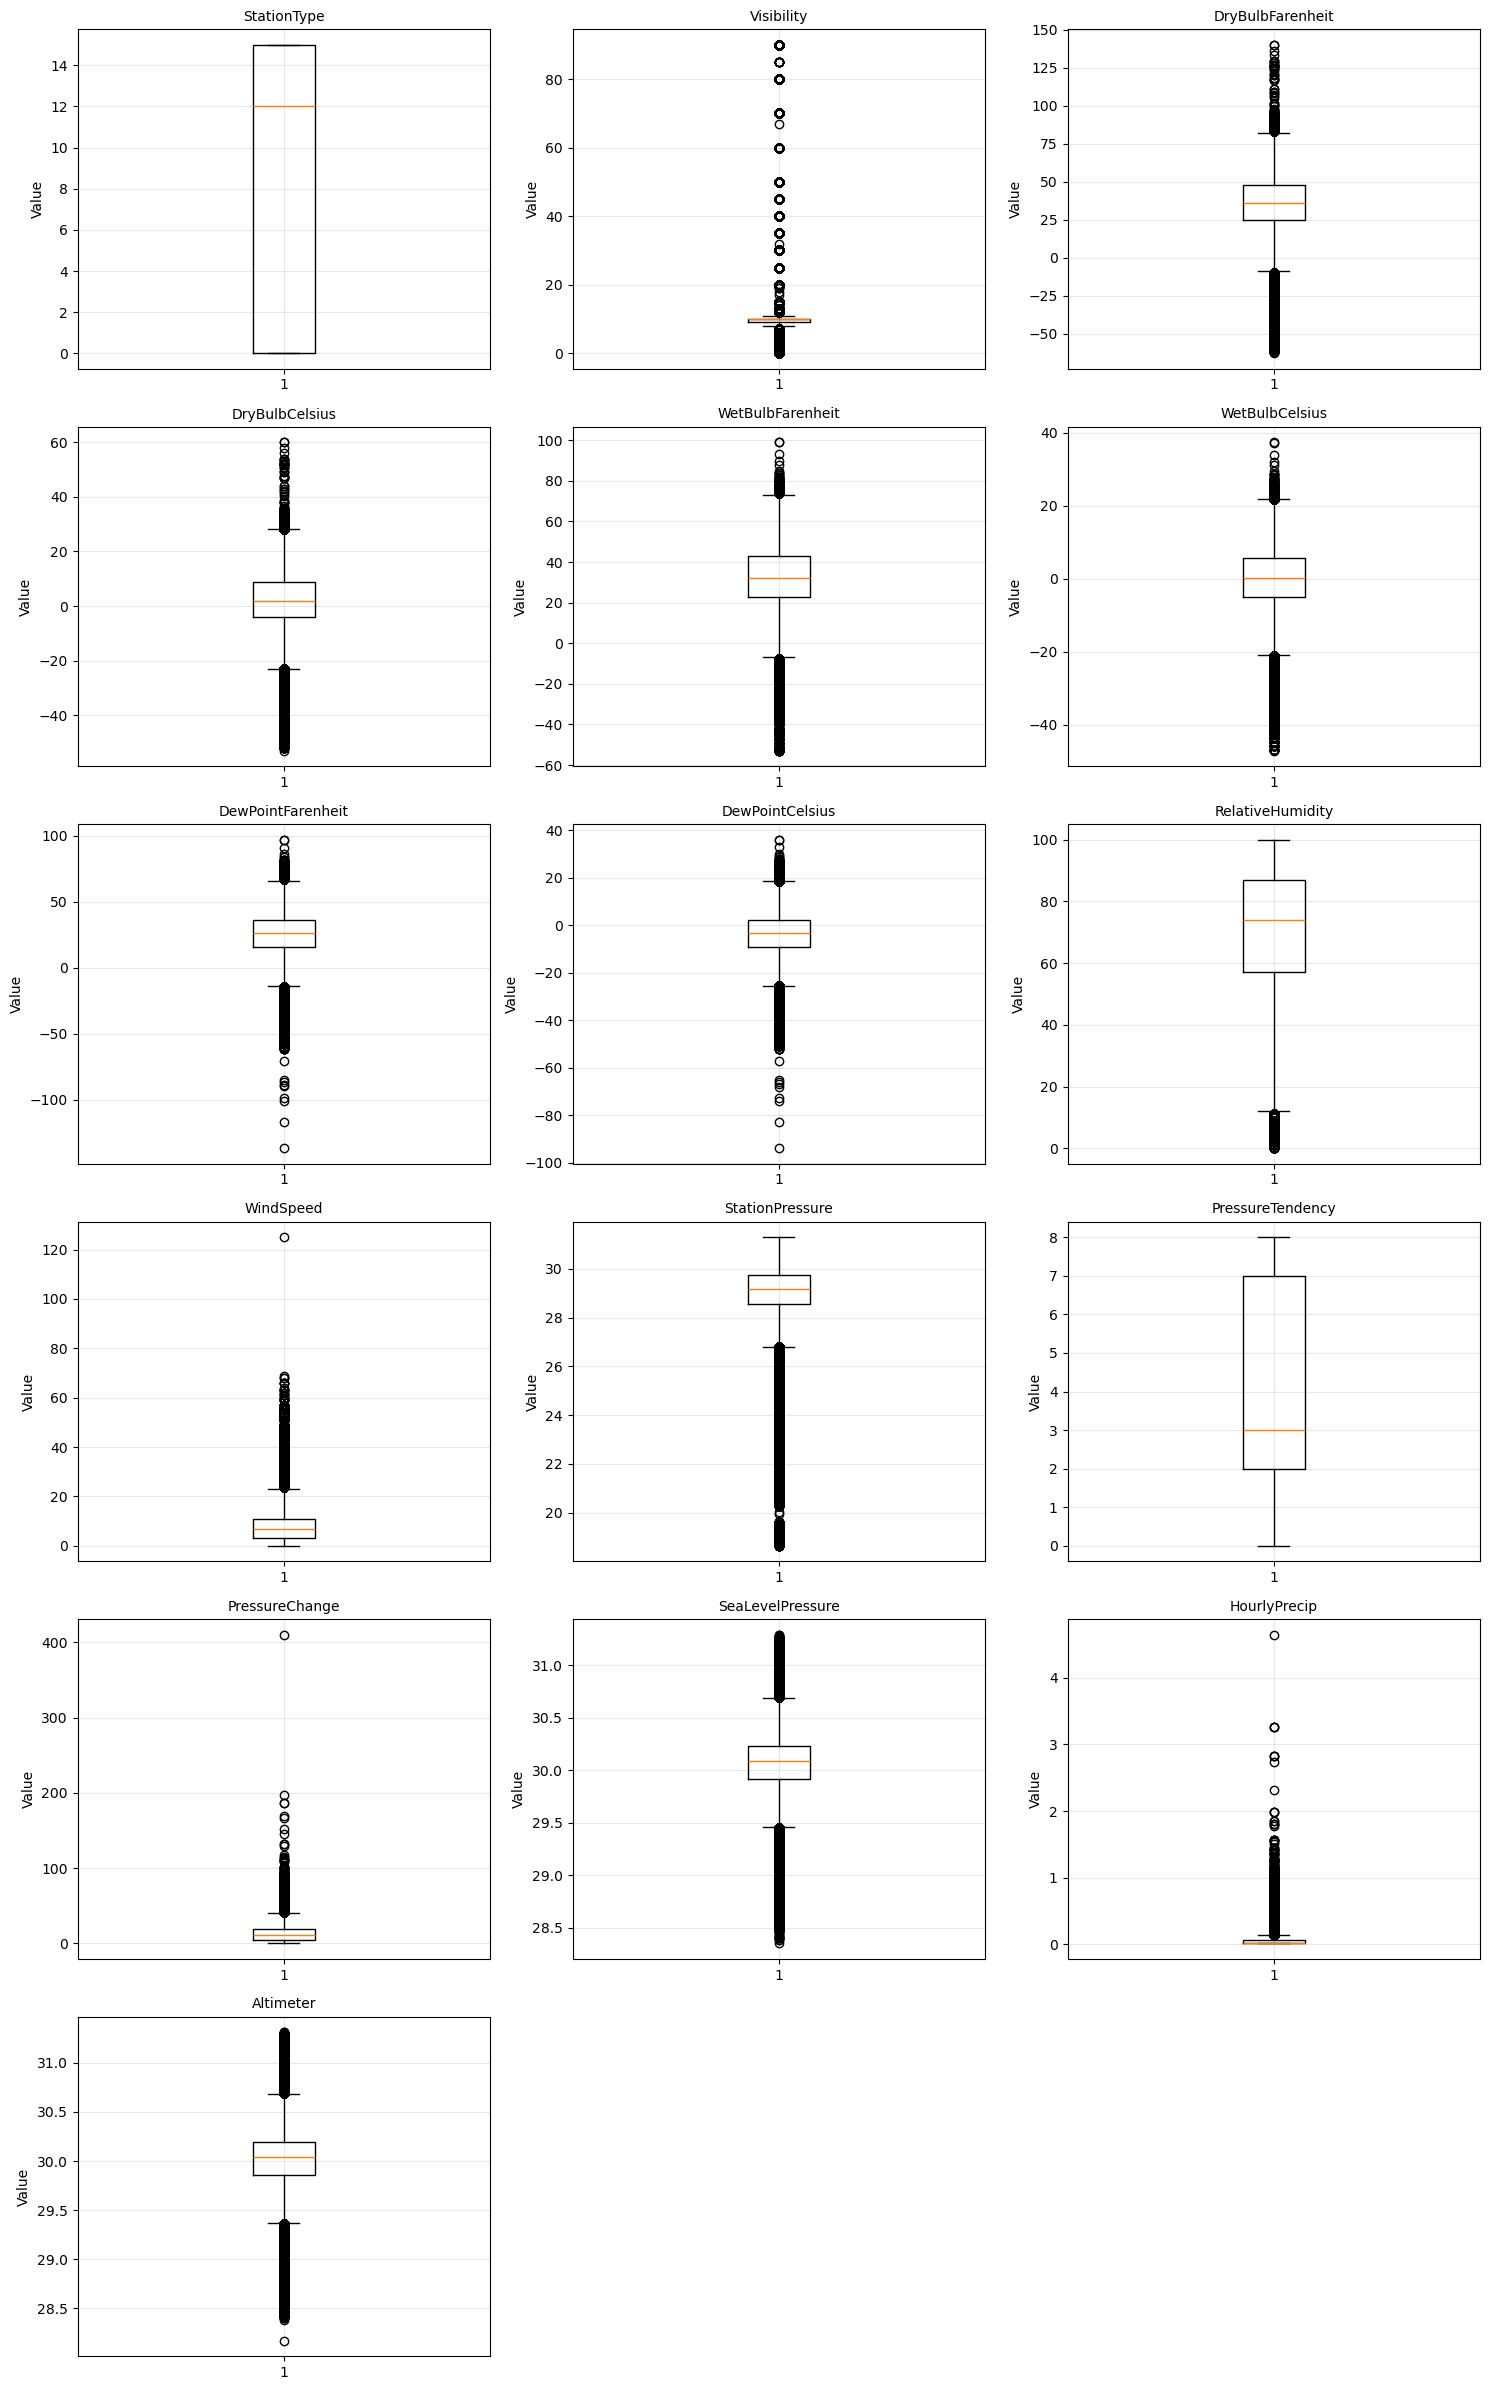

In [19]:
def plot_boxplots(df, columns, cols_per_row=3):
    non_null_cols = [col for col in columns if df[col].null_count() < df.height]

    if not non_null_cols:
        return

    n_cols = len(non_null_cols)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row

    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(15, 4 * n_rows))
    axes = axes.flatten() if n_rows > 1 or cols_per_row > 1 else [axes]

    for idx, col in enumerate(non_null_cols):
        ax = axes[idx]
        data = df[col].drop_nulls().to_numpy()

        if len(data) > 0:
            ax.boxplot(data, vert=True)
            ax.set_title(f'{col}', fontsize=10)
            ax.set_ylabel('Value')
            ax.grid(True, alpha=0.3)

    for idx in range(len(non_null_cols), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


plot_boxplots(df, numeric_columns)


## Statistical Summary for All Numeric Variables

In [24]:
# Filter out columns that are all null, then describe
valid_numeric_cols = [
    col for col in numeric_columns 
    if df[col].null_count() < df.height
]
detailed_stats = df.select(valid_numeric_cols).describe()
print(detailed_stats)

for col in numeric_columns:
    if df[col].null_count() < df.height:
        stats = df[col].drop_nulls()
        print(f"\n{col}:")
        print(f"  Count: {stats.len():,}")
        print(f"  Mean: {stats.mean():.2f}")
        print(f"  Median: {stats.median():.2f}")
        print(f"  Std Dev: {stats.std():.2f}")
        print(f"  Min: {stats.min():.2f}")
        print(f"  Max: {stats.max():.2f}")

shape: (9, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ StationTy ┆ Visibilit ┆ DryBulbFa ┆ … ┆ PressureC ┆ SeaLevelP ┆ HourlyPre ┆ Altimete │
│ ---       ┆ pe        ┆ y         ┆ renheit   ┆   ┆ hange     ┆ ressure   ┆ cip       ┆ r        │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 4.192912e ┆ 2.361122e ┆ 4.168905e ┆ … ┆ 288461.0  ┆ 818420.0  ┆ 96228.0   ┆ 2.387115 │
│           ┆ 6         ┆ 6         ┆ 6         ┆   ┆           ┆           ┆           ┆ e6       │
│ null_coun ┆ 0.0       ┆ 1.83179e6 ┆ 24007.0   ┆ … ┆ 3.904451e ┆ 3.374492e ┆ 4.096684e ┆ 1.805797 │
│ t         ┆           ┆           ┆           ┆   ┆ 6         ┆ 6         

## Correlation Analysis

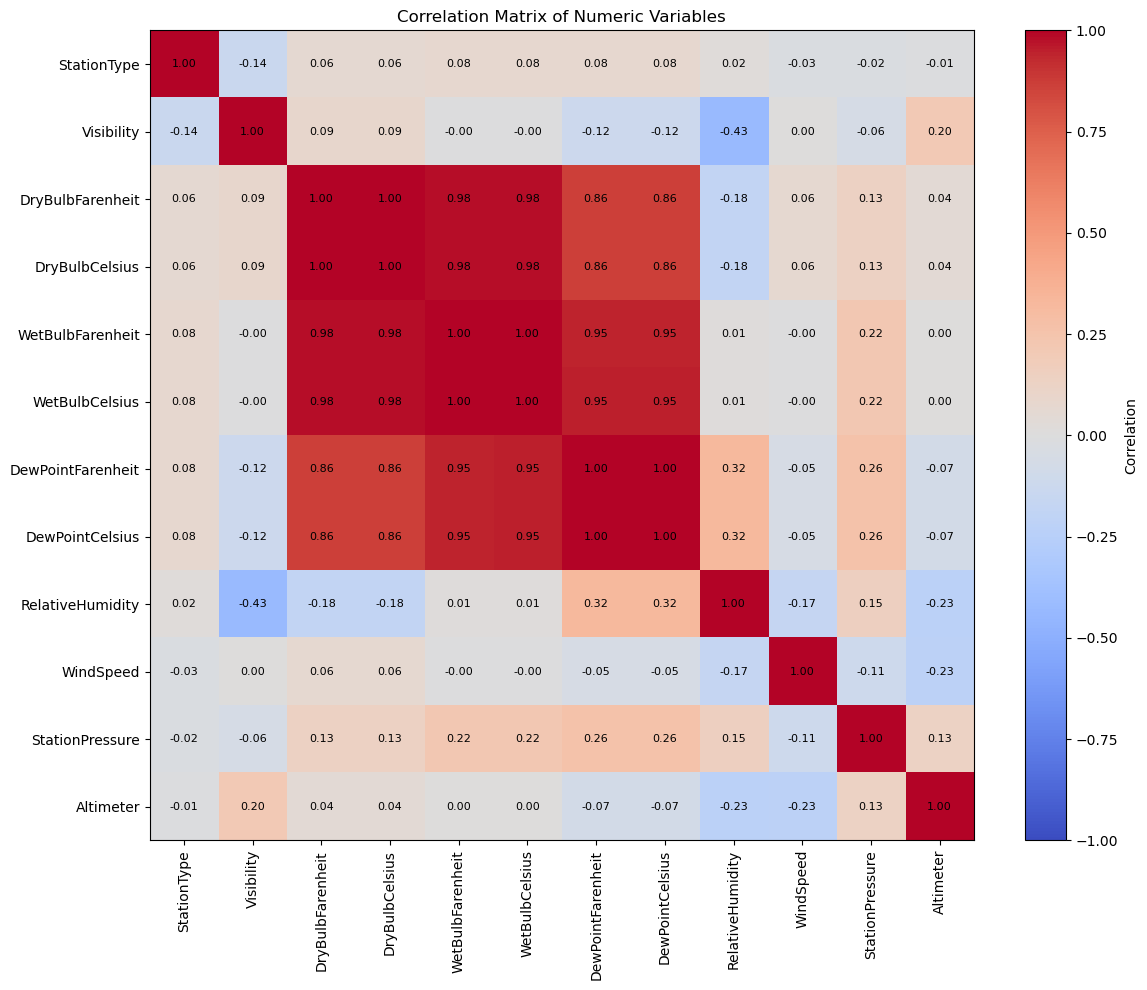

In [26]:
correlation_cols = [col for col in numeric_columns if df[col].null_count() < df.height * 0.5]

if len(correlation_cols) > 1:
    corr_df = df.select(correlation_cols).to_pandas().corr()

    plt.figure(figsize=(12, 10))
    plt.imshow(corr_df, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation')
    plt.xticks(range(len(correlation_cols)), correlation_cols, rotation=90)
    plt.yticks(range(len(correlation_cols)), correlation_cols)
    plt.title('Correlation Matrix of Numeric Variables')

    for i in range(len(correlation_cols)):
        for j in range(len(correlation_cols)):
            plt.text(j, i, f'{corr_df.iloc[i, j]:.2f}',
                     ha='center', va='center', color='black', fontsize=8)

    plt.tight_layout()
    plt.show()


ValueForWindCharacter Analysis:
Total records: 4,192,912
Non-null records: 4,192,912
Null records: 0
Non-null percentage: 100.00%

Unique values: 75


/var/folders/7c/qp7l8dn113s86r0x70snm3kw0000gn/T/ipykernel_2803/449343104.py:22: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()



Value Distribution:
shape: (75, 2)
┌───────────────────────┬─────────┐
│ ValueForWindCharacter ┆ count   │
│ ---                   ┆ ---     │
│ str                   ┆ u32     │
╞═══════════════════════╪═════════╡
│                       ┆ 3728936 │
│ 21                    ┆ 36085   │
│ 22                    ┆ 35518   │
│ 20                    ┆ 35073   │
│ 23                    ┆ 34790   │
│ …                     ┆ …       │
│ 88                    ┆ 1       │
│ 112                   ┆ 1       │
│ 114                   ┆ 1       │
│ 123                   ┆ 1       │
│ 129                   ┆ 1       │
└───────────────────────┴─────────┘

✅ Full distribution exported to: WindChar_dist.csv


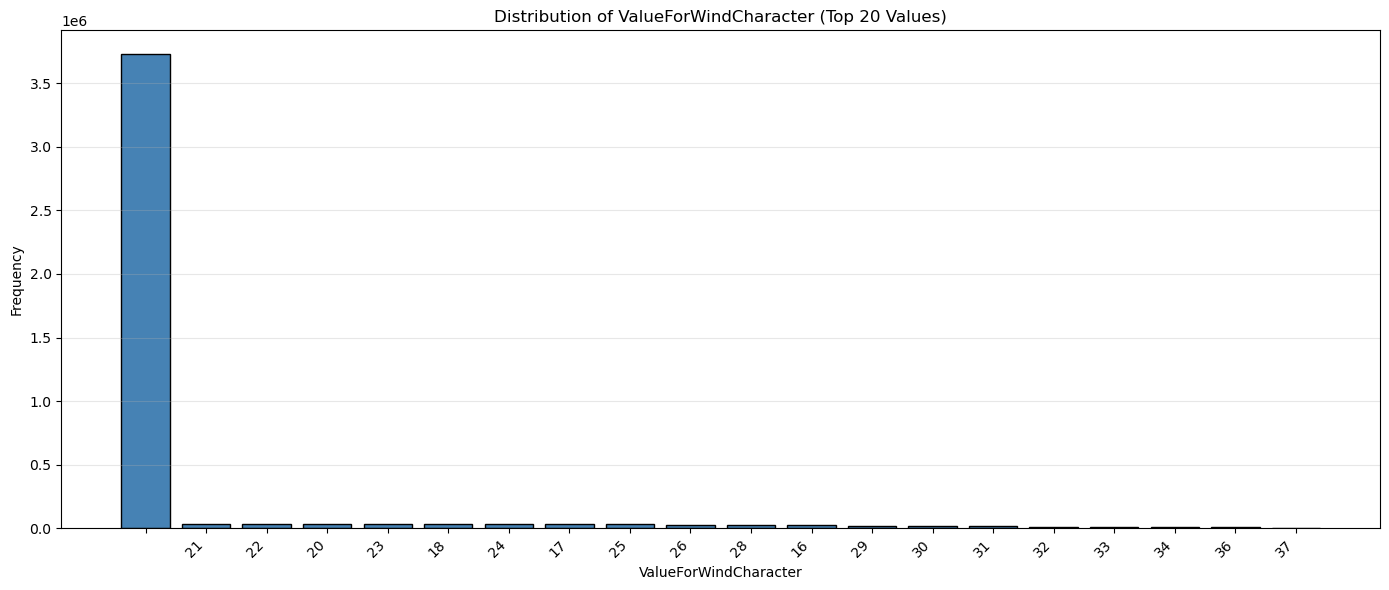

In [29]:
# Check if the column exists and has data
print("ValueForWindCharacter Analysis:")
print("=" * 60)

# Basic statistics
non_null_count = df["ValueForWindCharacter"].drop_nulls().len()
total_count = df.height
null_count = df["ValueForWindCharacter"].null_count()

print(f"Total records: {total_count:,}")
print(f"Non-null records: {non_null_count:,}")
print(f"Null records: {null_count:,}")
print(f"Non-null percentage: {(non_null_count/total_count)*100:.2f}%")

# Check unique values
unique_count = df["ValueForWindCharacter"].n_unique()
print(f"\nUnique values: {unique_count}")

# Get value counts (distribution)
value_distribution = (
    df.group_by("ValueForWindCharacter")
    .count()
    .sort("count", descending=True)
)

print("\nValue Distribution:")
print(value_distribution)

# Export the full distribution to CSV
csv_filename = "WindChar_dist.csv"
value_distribution.write_csv(csv_filename)
print(f"\n✅ Full distribution exported to: {csv_filename}")

# Visualize the distribution
import matplotlib.pyplot as plt

# Get top values for visualization
top_values = value_distribution.head(20).to_pandas()

if len(top_values) > 0:
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(top_values)), top_values['count'], color='steelblue', edgecolor='black')
    plt.xticks(range(len(top_values)), top_values['ValueForWindCharacter'], rotation=45, ha='right')
    plt.title('Distribution of ValueForWindCharacter (Top 20 Values)')
    plt.xlabel('ValueForWindCharacter')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization")

In [33]:
# --- 1. DEFINE THE MAPPINGS ---
# Dictionaries are the fastest lookup method for this
type_map = {
    # --- Rain ---
    21: 'Rain', 60: 'Rain', 61: 'Rain', 62: 'Rain', 63: 'Rain', 64: 'Rain', 65: 'Rain',
    # --- Freezing Rain / Drizzle ---
    24: 'Freezing_Precip', 56: 'Freezing_Precip', 57: 'Freezing_Precip', 66: 'Freezing_Precip', 67: 'Freezing_Precip',
    # --- Drizzle ---
    20: 'Drizzle', 50: 'Drizzle', 51: 'Drizzle', 52: 'Drizzle', 53: 'Drizzle', 54: 'Drizzle', 55: 'Drizzle',
    # --- Snow ---
    22: 'Snow', 70: 'Snow', 71: 'Snow', 72: 'Snow', 73: 'Snow', 74: 'Snow', 75: 'Snow',
    # --- Rain & Snow Mix ---
    23: 'Rain_Snow_Mix', 68: 'Rain_Snow_Mix', 69: 'Rain_Snow_Mix',
    # --- Showers (Rain/Snow) ---
    25: 'Shower', 26: 'Shower', 80: 'Shower', 81: 'Shower', 82: 'Shower', 83: 'Shower', 84: 'Shower', 85: 'Shower', 86: 'Shower',
    # --- Thunderstorm ---
    17: 'Thunderstorm', 29: 'Thunderstorm', 95: 'Thunderstorm', 96: 'Thunderstorm', 97: 'Thunderstorm', 99: 'Thunderstorm',
    # --- Fog / Mist / Haze ---
    10: 'Fog_Mist', 28: 'Fog_Mist', 40: 'Fog_Mist', 41: 'Fog_Mist', 42: 'Fog_Mist', 43: 'Fog_Mist', 44: 'Fog_Mist', 45: 'Fog_Mist',
    5: 'Haze',
    # --- Other ---
    18: 'Squall',
    30: 'Dust_Sand', 31: 'Dust_Sand', 32: 'Dust_Sand', 33: 'Dust_Sand', 34: 'Dust_Sand', 35: 'Dust_Sand',
    36: 'Blowing_Snow', 37: 'Blowing_Snow', 38: 'Blowing_Snow', 39: 'Blowing_Snow'
}

intensity_map = {
    # --- Light ---
    50: 'Light', 51: 'Light', 60: 'Light', 61: 'Light', 70: 'Light', 71: 'Light',
    80: 'Light', 83: 'Light', 85: 'Light',
    # --- Moderate ---
    52: 'Moderate', 53: 'Moderate', 62: 'Moderate', 63: 'Moderate', 72: 'Moderate', 73: 'Moderate',
    81: 'Moderate', 84: 'Moderate', 86: 'Moderate',
    # --- Heavy ---
    54: 'Heavy', 55: 'Heavy', 64: 'Heavy', 65: 'Heavy', 74: 'Heavy', 75: 'Heavy',
    82: 'Heavy', 87: 'Heavy', 88: 'Heavy',
    # --- Heavy + Thunderstorm ---
    97: 'Heavy', 99: 'Heavy'
}

# --- 2. CREATE A SAMPLE DATAFRAME ---
# This simulates your raw project data
data = {'ValueForWindCharacter': [61, 65, 22, 29, 0, 31, 52, None]}
df = pl.DataFrame(data)

print("--- Original Polars DataFrame ---")
print(df)


# --- 3. APPLY MAPPINGS & CLEANUP ---
# We use with_columns to create new columns based on expressions
# This is where the Polars-native mapping happens.
df_mapped = df.with_columns(
    Weather_Type = pl.col("ValueForWindCharacter")
                     .cast(pl.String)
                     .replace(type_map)
                     .fill_null("Clear_or_Other"),
    
    Weather_Intensity = pl.col("ValueForWindCharacter")
                          .cast(pl.String)
                          .replace(intensity_map)
                          .fill_null("Not_Applicable")
)

print("\n--- DataFrame After Mapping ---")
print(df_mapped)

# --- 4. ONE-HOT ENCODING ---
# This single command creates all the dummy columns
# and drops the intermediate string columns.
#df_final = df_mapped.to_dummies(columns=["Weather_Type", "Weather_Intensity"])

#print("\n--- Final DataFrame Ready for Model (Polars) ---")
#print(df_final)

--- Original Polars DataFrame ---
shape: (8, 1)
┌───────────────────────┐
│ ValueForWindCharacter │
│ ---                   │
│ i64                   │
╞═══════════════════════╡
│ 61                    │
│ 65                    │
│ 22                    │
│ 29                    │
│ 0                     │
│ 31                    │
│ 52                    │
│ null                  │
└───────────────────────┘

--- DataFrame After Mapping ---
shape: (8, 3)
┌───────────────────────┬────────────────┬───────────────────┐
│ ValueForWindCharacter ┆ Weather_Type   ┆ Weather_Intensity │
│ ---                   ┆ ---            ┆ ---               │
│ i64                   ┆ str            ┆ str               │
╞═══════════════════════╪════════════════╪═══════════════════╡
│ 61                    ┆ Rain           ┆ Light             │
│ 65                    ┆ Rain           ┆ Heavy             │
│ 22                    ┆ Snow           ┆ 22                │
│ 29                    ┆ Thunderstor